# Compare bottom water transport vs upwelling

And mean/eddy decompositions of cross-SSH contour bottom water transport

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import scipy.stats as ss
from collections import OrderedDict
from matplotlib import gridspec

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

import gcm_filters

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33365/status,
Dashboard: /proxy/33365/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34555,Workers: 7
Dashboard: /proxy/33365/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://10.6.121.4:40125,Total threads: 4
Dashboard: /proxy/39985/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:39961,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load important parameters

In [4]:
expt = '01deg_jra55v13_ryf9091'
# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## define study region ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)

In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 8.57 s, sys: 1.97 s, total: 10.5 s
Wall time: 1min 25s


In [7]:
%%time

dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)


CPU times: user 5.19 s, sys: 1.06 s, total: 6.24 s
Wall time: 1min 6s


### Load layer thickness height average

In [8]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
h_bar = xr.open_dataset(save_dir+'h_bar_10yr.nc').h_bar
vh_bar = xr.open_dataset(save_dir+'vh_bar_10yr.nc').vh_bar/rho_0 # because I forgot to divide by rho_0 when making it
uh_bar = xr.open_dataset(save_dir+'uh_bar_10yr.nc').uh_bar/rho_0
v_bar = xr.open_dataset(save_dir+'v_bar_10yr.nc').v_bar
u_bar = xr.open_dataset(save_dir+'u_bar_10yr.nc').u_bar


In [9]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

### cumulative sum plot definitions
get_eddy_meanresidual extracts mean, residual and eddy terms

find_along_contour_index_positions_of_given_longitudes gets data required to have axis labels as longitude rather than distance along contour

In [10]:
def get_eddymeanresidual(j_contour):
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
        prefix = 400
    else:
        suffix = ''
        prefix = 0
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

    vh_0 = xr.open_dataset(save_dir+'vol_trans_across_contour_binned.nc')
    vh_0 = vh_0.vol_trans_across_contour_binned
    vh_0 = vh_0.load()

    h_0 = xr.open_dataset(save_dir+'dzu_across_contour_binned.nc')
    h_0 = h_0.dzu_across_contour_binned
    h_0 = h_0.load()

    v_0 = vh_0/h_0
    v_0 = v_0.where(v_0!=np.inf).where(v_0 !=-np.inf).fillna(0)


    v = v_0
    h = h_0
    vh = vh_0

    v_bar = v.mean('time')
    v_bar = v_bar.where(v_bar!=np.inf).where(v_bar !=-np.inf).fillna(0)
    v_bar.load()
    h_bar = h.mean('time')
    h_bar = h_bar.where(v_bar!=np.inf).where(v_bar !=-np.inf).fillna(0)
    h_bar.load()

    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+'.nc').vh_eddy
    vh_bar = vh.mean('time')
    vh_mean = v_bar*h_bar
    return vh_eddy, vh_bar, vh_mean

In [11]:
def find_contour_index_positions_of_given_longitudes(j_contour):
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour

    # run above distance indices code
    distance_indices = np.zeros(8)
    for i in np.arange(100,len(lon_along_contour.values)):
        if (distance_indices[1]==0):
            if (lon_along_contour.values[i]>-240):
                distance_indices[1] = lon_along_contour.contour_index.values[i]
        if (distance_indices[2]==0):
            if (lon_along_contour.values[i]>-180):
                distance_indices[2] = lon_along_contour.contour_index.values[i]
        if (distance_indices[3]==0):
            if (lon_along_contour.values[i]>-120):
                distance_indices[3] = lon_along_contour.contour_index.values[i]
        if (distance_indices[4]==0):
            if lon_along_contour.values[i]>-60:
                distance_indices[4] = lon_along_contour.contour_index.values[i]
        if (distance_indices[5]==0):
            if (lon_along_contour.values[i]>0):
                distance_indices[5] = lon_along_contour.contour_index.values[i]
        if (distance_indices[6]==0):
            if (lon_along_contour.values[i]>60):
                distance_indices[6] = lon_along_contour.contour_index.values[i]
    distance_indices[7] = len(lon_along_contour.contour_index.values)-1
    return distance_indices

### Bottom vs upwelling arm

- cumulative cross-SSH eddy transport for different constant density ranges
- upwelling arm is densities that in zonal average don't touch surface and don't go northward
- bottom arm is densities below that (in this SSH=-1.2m contour, it is sigma_1 = 1032.53)

Text(0.5, 1.0, 'SSH= -1.2 m')

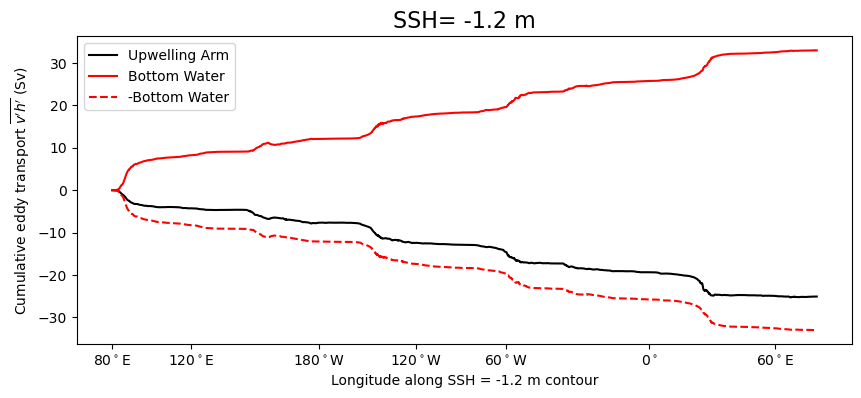

In [47]:
j_contour = 'L'
vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+'.nc').vh_eddy
bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff.sel(hotspot = 'total')
# mask out water that touches surface or bottom on average
SSH = contour_dict[j_contour]['SSH']
if SSH > -0.45:
    print('SSH too big!!')
rhoslice_up = slice(top_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0],bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0])

rhoslice_bottom = slice(bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0], 1033)
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'
distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
distance_indices = find_contour_index_positions_of_given_longitudes(j_contour)

fig = plt.figure(figsize = (10,4))
plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_up).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'k', label = 'Upwelling Arm')
plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r', label = 'Bottom Water')
plt.plot(distance,-vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r',linestyle = '--', label = '-Bottom Water')
plt.xticks(distance.values[distance_indices.astype(int)[:-1]], 
           ('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
plt.legend()
plt.xlabel('Longitude along SSH = '+str(SSH)+' m contour')
plt.ylabel('Cumulative eddy transport $\overline{v^\prime h^\prime}$ (Sv)')
plt.title('SSH= '+str(SSH)+' m', fontsize = 16)

### below, upwelling arm is defined to go to the top of the ocean
- now including all water crossing SSH=-1.2m. 
- shows approximately closed eddy transport, hotspots in same place as upwelling

In [58]:
def plot_eddy_bottom_vs_notbottom(j_contour):
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+'.nc').vh_eddy
    bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
    top_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_top_density_cutoffs.nc').top_cutoff.sel(hotspot = 'total')
    # mask out water that touches surface or bottom on average
    SSH = contour_dict[j_contour]['SSH']
    if SSH > -0.45:
        print('SSH too big!!')
    # rhoslice_up = slice(top_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0],bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0])
    rhoslice_up = slice(1000,bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0])

    rhoslice_bottom = slice(bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0], 1033)
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

    distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
    distance_indices = find_contour_index_positions_of_given_longitudes(j_contour)


    fig = plt.figure(figsize = (10,4))
    plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_up).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'k', label = 'Upwelling Arm/surface')
    plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r', label = 'Bottom Water')
    plt.plot(distance,-vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r',linestyle = '--', label = '-Bottom Water')
    plt.xticks(distance.values[distance_indices.astype(int)[:-1]], 
               ('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
    plt.legend()
    plt.xlabel('Longitude along SSH = '+str(SSH)+' m contour')
    plt.ylabel('Cumulative eddy transport $\overline{v^\prime h^\prime}$ (Sv)')
    plt.title('SSH= '+str(SSH)+' m', fontsize = 16)

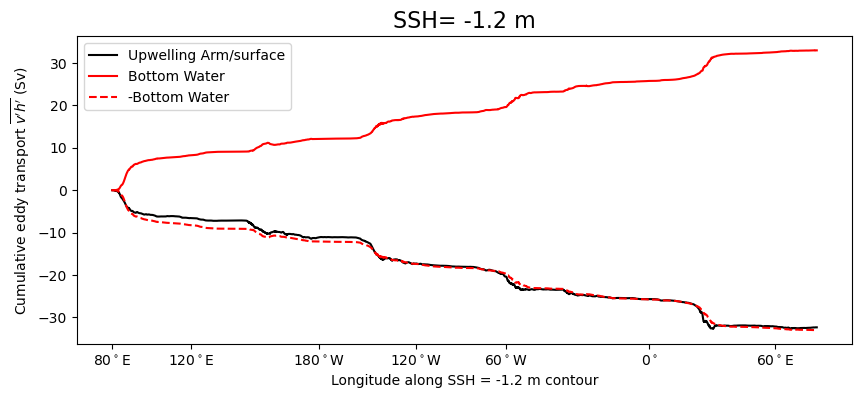

In [59]:
j_contour = 'L'
plot_eddy_bottom_vs_notbottom(j_contour)

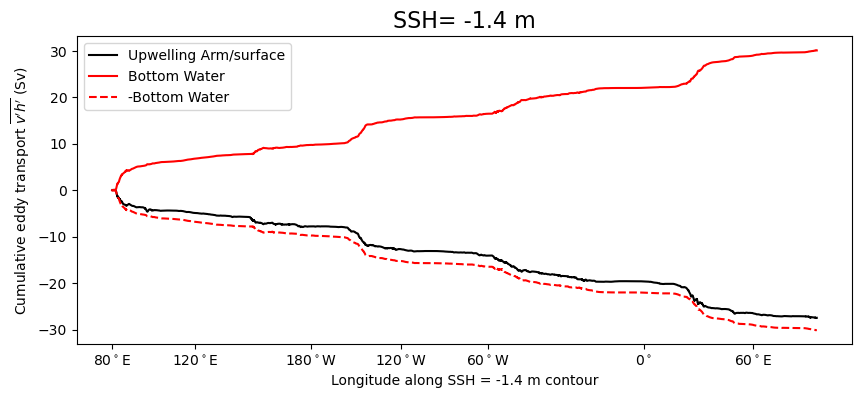

In [60]:
j_contour = 'N'
plot_eddy_bottom_vs_notbottom(j_contour)

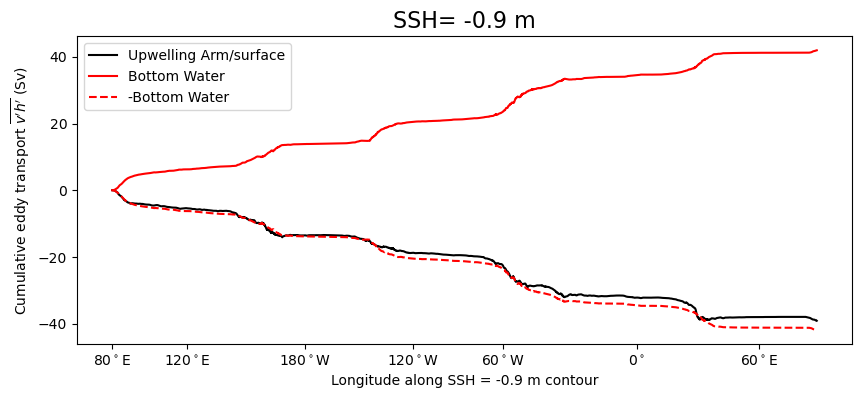

In [61]:
j_contour = 'I'
plot_eddy_bottom_vs_notbottom(j_contour)

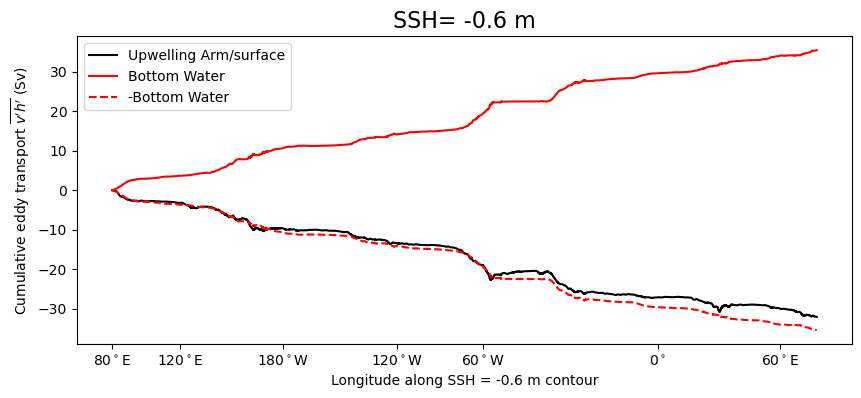

In [62]:
j_contour = 'F'
plot_eddy_bottom_vs_notbottom(j_contour)

### average height of bottom cutoff (between upwelling arm and bottom water)

mean depth
2531.300451526215


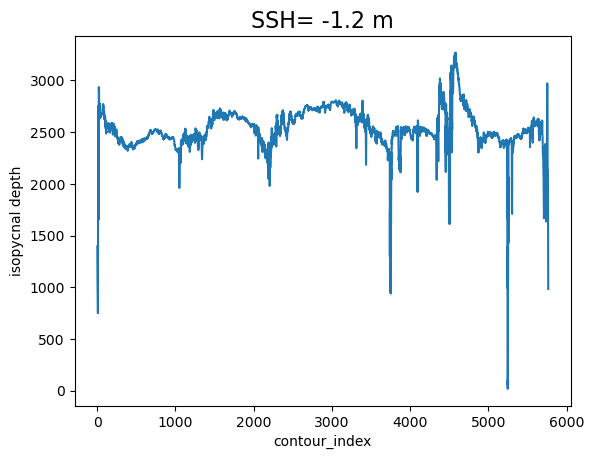

In [49]:
h_bar = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/h_bar_contour_SO_'+j_contour+'.nc').h_bar
h_bar.cumsum('isopycnal_bins').sel(isopycnal_bins = bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0]).plot()
plt.ylabel('isopycnal depth')
plt.title('SSH= '+str(SSH)+' m', fontsize = 16)
print('mean depth')
print(h_bar.cumsum('isopycnal_bins').sel(isopycnal_bins = bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0]).mean().values)

# Decompose bottom water residual cross-contour transport into mean and eddy terms
- for various SSH contours, starting from southernmost

In [63]:
def plot_mean_residual_eddy_bottom_water(j_contour):
    SSH = contour_dict[j_contour]['SSH']
    vh_eddy, vh_bar, vh_mean = get_eddymeanresidual(j_contour)
    bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
    rhoslice_bottom = slice(bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0], 1033)
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

    distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
    distance_indices = find_contour_index_positions_of_given_longitudes(j_contour)
    fig = plt.figure(figsize = (10,4))
    #plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_up).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'k', label = 'Upwelling Arm')
    plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r', label = 'Bottom Water eddy $\overline{v^\prime h^\prime}$')
    #plt.plot(distance,-vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r',linestyle = '--', label = '-Bottom Water')
    plt.plot(distance,vh_mean.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'm', label = 'Bottom Water mean $\overline{v}\overline{h}$')
    plt.plot(distance,vh_bar.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'b', label = 'Bottom Water residual $\overline{vh}$')

    plt.xticks(distance.values[distance_indices.astype(int)[:-1]], 
               ('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
    plt.legend()
    plt.xlabel('Longitude along SSH = '+str(SSH)+' m contour')
    plt.ylabel('Cumulative transport (Sv)')
    print('eddy total')
    print(vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
    print('mean total')
    print(vh_mean.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
    print('residual total')
    print(vh_bar.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
    plt.title('SSH= '+str(SSH)+' m', fontsize = 16)

eddy total
30.107993769629022
mean total
-13.272914327405518
residual total
15.625273116392869


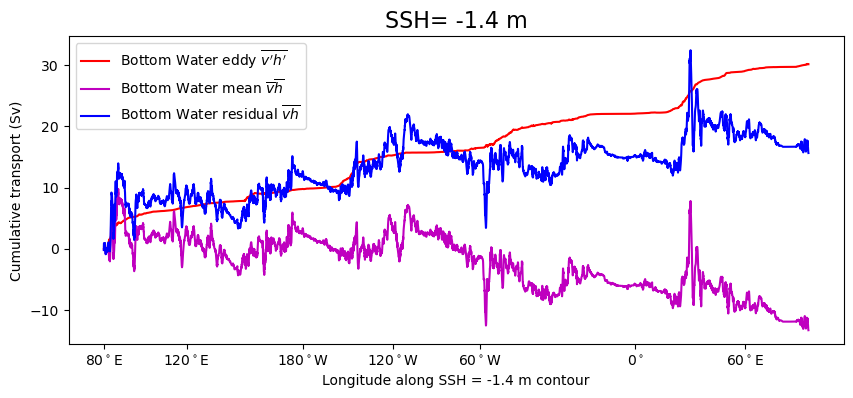

In [64]:
j_contour = 'N'
plot_mean_residual_eddy_bottom_water(j_contour)

eddy total
32.965402313546555
mean total
-14.6168640020727
residual total
16.648753016176922


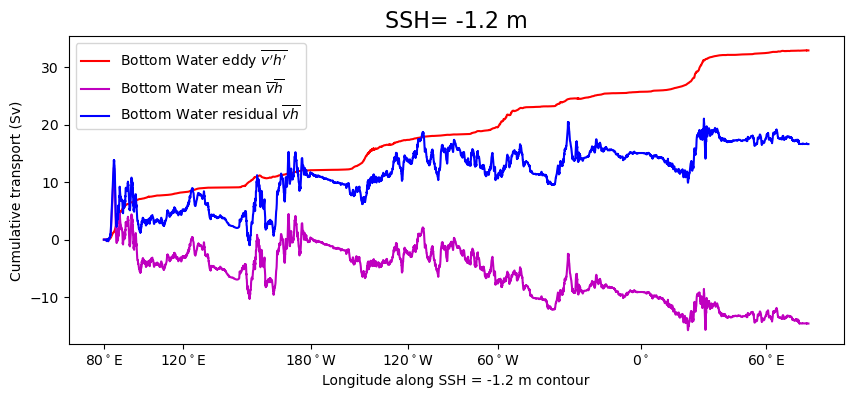

In [65]:
j_contour = 'L'
plot_mean_residual_eddy_bottom_water(j_contour)

eddy total
41.97595610504835
mean total
-20.297863221067754
residual total
15.673970584870528


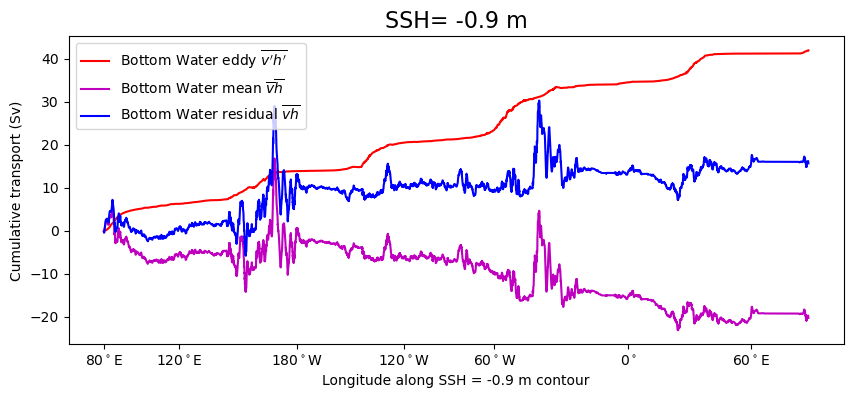

In [66]:
j_contour = 'I'
plot_mean_residual_eddy_bottom_water(j_contour)

eddy total
43.173730580703065
mean total
-23.294342650735462
residual total
10.77107885542122


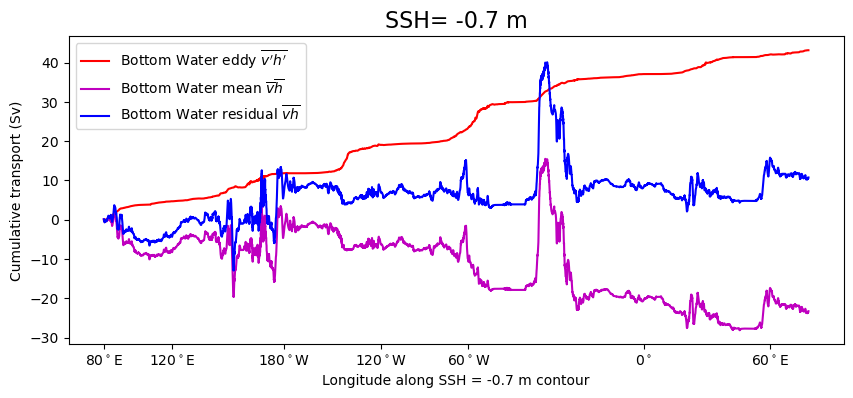

In [67]:
j_contour = 'G'
plot_mean_residual_eddy_bottom_water(j_contour)

# the same plot, at the surface (arbitrarily chosen as sigma_1 < 1031.5) (as a check)

- variations in mean and eddy in above plots are likely due to mean flow crossing the contours at depth as flow doesn't completely follow SSH contours at depth
- since the surface plot doesn't have those same variations

eddy
-4.96884629794862
mean
9.68976549313926
residual
6.470122607076373


Text(0.5, 1.0, 'SSH= -1.2 m')

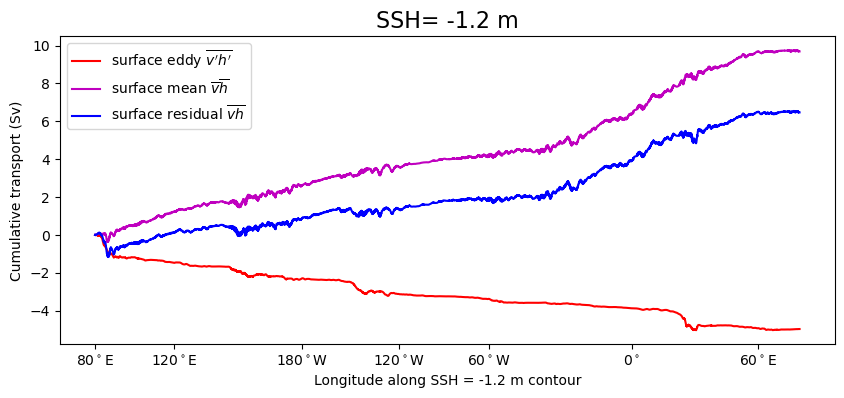

In [54]:
j_contour = 'L'
SSH = contour_dict[j_contour]['SSH']
vh_eddy, vh_bar, vh_mean = get_eddymeanresidual(j_contour)
bottom_cutoff = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/hotspot_bottom_density_cutoffs.nc').bottom_cutoff.sel(hotspot = 'total')
#rhoslice_bottom = slice(bottom_cutoff.sel(SSH=slice(SSH-0.01,SSH+0.01)).values[0], 1033)
rhoslice_bottom = slice(1030,1031.5)
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
distance_indices = find_contour_index_positions_of_given_longitudes(j_contour)
fig = plt.figure(figsize = (10,4))
#plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_up).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'k', label = 'Upwelling Arm')
plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r', label = 'surface eddy $\overline{v^\prime h^\prime}$')
#plt.plot(distance,-vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r',linestyle = '--', label = '-Bottom Water')
plt.plot(distance,vh_mean.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'm', label = 'surface mean $\overline{v}\overline{h}$')
plt.plot(distance,vh_bar.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'b', label = 'surface residual $\overline{vh}$')

plt.xticks(distance.values[distance_indices.astype(int)[:-1]], 
           ('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
plt.legend()
plt.xlabel('Longitude along SSH = '+str(SSH)+' m contour')
plt.ylabel('Cumulative transport (Sv)')
print('eddy')
print(vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('mean')
print(vh_mean.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('residual')
print(vh_bar.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
plt.title('SSH= '+str(SSH)+' m', fontsize = 16)

# Montgomery Potential contour
A contour at very similar location to SSH=-1.2 in density layer sigma_1 = 1032.5

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.09 s


Text(0.5, 0, 'Longitude')

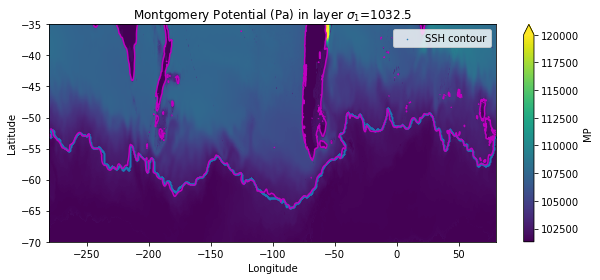

In [23]:
%%time
MP = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MP_10yr.nc').MP

L = 'SO_ocean_contour_smoothed_u_t_-1.2m_SSH_plt_approach.npz'
outfile = '/g/data/x77/cy8964/Post_Process/'+L
data = np.load(outfile)
lon_along_contour=data['lon_along_contour_t']
lat_along_contour=data['lat_along_contour_t']

fig = plt.figure(figsize = (10,4))
MP.sel(isopycnal_bins =1032.5).plot(vmax = 120000)
MP.sel(isopycnal_bins =1032.5).plot.contour(levels = [102400],colors = 'm')
plt.scatter(lon_along_contour,lat_along_contour,label = 'SSH contour',s = 0.3)
plt.legend()
plt.title('Montgomery Potential (Pa) in layer $\sigma_1$=1032.5')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

load contour volume transport and dzu binned in sigma_1

In [8]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_L_MP_'
h = xr.open_dataset(save_dir+'dzu_along_contour_binned.nc').dzu_along_contour_binned
vh = xr.open_dataset(save_dir+'vol_trans_across_contour_binned.nc').vol_trans_across_contour_binned

In [9]:
%%time
## load mean (v_bar*h_bar) and residual ((vh)_bar)
v = vh/h
v = v.where(v!=np.inf).where(v !=-np.inf).fillna(0)
v_bar = v.mean('time')
v_bar.load()

h_bar = h.mean('time')
h_bar.load()

vh_mean = v_bar*h_bar

vh_residual = vh.mean('time')
vh_residual.load()
# load eddy
vh_eddy = (v-v_bar)*(h-h_bar)
vh_eddy = vh_eddy.mean('time')
vh_eddy.load()

CPU times: user 1min 51s, sys: 12min 30s, total: 14min 21s
Wall time: 13min 47s


<xarray.DataArray (isopycnal_bins: 31, contour_index: 6300)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1.001e+03 1.028e+03 ... 1.045e+03
  * contour_index   (contour_index) int64 1 2 3 4 5 ... 6296 6297 6298 6299 6300

eddy total
28.977854174487206
mean total
-16.275177273701715
residual total
12.702676900785457


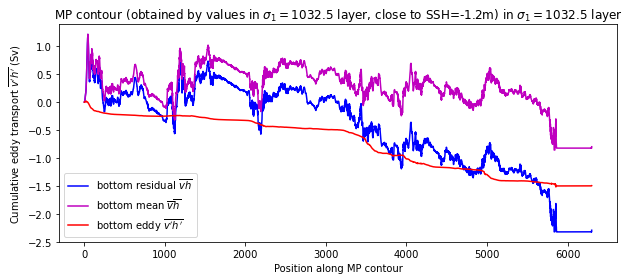

In [24]:
fig = plt.figure(figsize = (10,4))
rhoslice = slice(1032.495,1032.505) # this is one layer, 1032.5
(vh_residual.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6).plot(color = 'b', label = 'bottom residual $\overline{vh}$')
(vh_mean.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6).plot(color = 'm', label = 'bottom mean $\overline{v}\overline{h}$')
(vh_eddy.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6).plot(color = 'r', label = 'bottom eddy $\overline{v^\prime h^\prime }$')

plt.legend()
plt.xlabel('Position along MP contour')
plt.ylabel('Cumulative eddy transport $\overline{v^\prime h^\prime}$ (Sv)')
plt.title('MP contour (obtained by values in $\sigma_1=1032.5$ layer, close to SSH=-1.2m) in $\sigma_1=1032.5$ layer', fontsize = 12)
print('eddy total')
print(vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('mean total')
print(vh_mean.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('residual total')
print(vh_residual.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)

compare to result in sigma_1 = 1032.5 for original SSH contour -1.2m:

eddy
-1.7539465077785354
mean
-0.6939576552898759
residual
-2.445549858067789


Text(0.5, 1.0, 'SSH= -1.2 m')

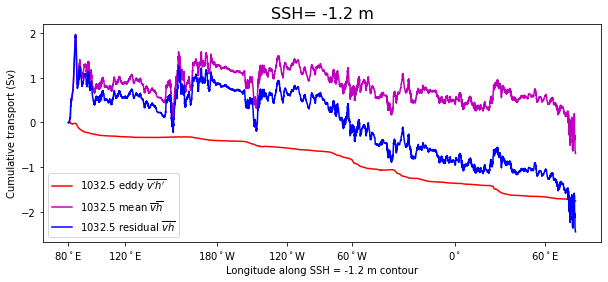

In [14]:
j_contour = 'L'
SSH = contour_dict[j_contour]['SSH']
vh_eddy, vh_bar, vh_mean = get_eddymeanresidual(j_contour)
rhoslice = slice(1032.495,1032.505) # this is one layer, 1032.5
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
distance_indices = find_contour_index_positions_of_given_longitudes(j_contour)
fig = plt.figure(figsize = (10,4))
#plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_up).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'k', label = 'Upwelling Arm')
plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r', label = '1032.5 eddy $\overline{v^\prime h^\prime}$')
#plt.plot(distance,-vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r',linestyle = '--', label = '-Bottom Water')
plt.plot(distance,vh_mean.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'm', label = '1032.5 mean $\overline{v}\overline{h}$')
plt.plot(distance,vh_bar.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'b', label = '1032.5 residual $\overline{vh}$')

plt.xticks(distance.values[distance_indices.astype(int)[:-1]], 
           ('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
plt.legend()
plt.xlabel('Longitude along SSH = '+str(SSH)+' m contour')
plt.ylabel('Cumulative transport (Sv)')
print('eddy')
print(vh_eddy.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('mean')
print(vh_mean.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('residual')
print(vh_bar.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').sum('contour_index').values/1e6)
plt.title('SSH= '+str(SSH)+' m', fontsize = 16)

Not much difference using Montomergy Potential in a layer for transports in that same layer, versus SSH.

# Transport over 60S 
- to see if mean is southward or northward
- looks like that over latitude circles, mean is northward (opposite to SSH contours)

CPU times: user 2.73 s, sys: 0 ns, total: 2.73 s
Wall time: 2.59 s


Text(80, 5.4178525380025375, '6.42')

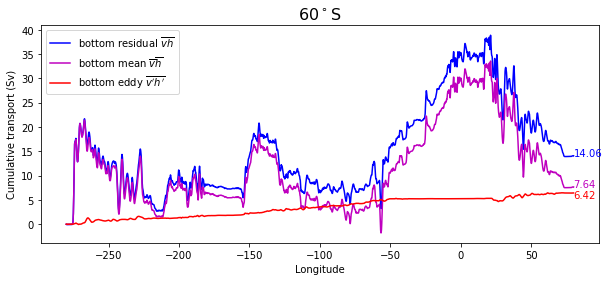

In [28]:
%%time
fig = plt.figure(figsize = (10,4))
rhoslice_bottom = slice(1032.53,1036)
lat = -60
dxt_60S = dxt.sel(yt_ocean = lat , method = 'nearest')
dxt_60S = dxt_60S.load()
vh_total_dx = ((vh_bar/1e6).sel(yt_ocean = lat , method = 'nearest').sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins')*dxt_60S)
vh_total_dx.cumsum('xt_ocean').plot(color = 'b', label = 'bottom residual $\overline{vh}$')
vh_mean_dx = ((v_bar*h_bar/1e6).sel(yt_ocean = lat , method = 'nearest').sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins')*dxt_60S)
vh_mean_dx.cumsum('xt_ocean').plot(color = 'm', label = 'bottom mean $\overline{v}\overline{h}$')
## eddy is calculated as a residual here for speed, but I have checked that the v'h' calculation is the same
vh_eddy_dx = (((vh_bar-v_bar*h_bar)/1e6).sel(yt_ocean =lat , method = 'nearest').sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins')*dxt_60S)
vh_eddy_dx.cumsum('xt_ocean').plot(color = 'r', label = 'bottom eddy $\overline{v^\prime h^\prime}$')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Cumulative transport (Sv)')
plt.title('60$^\circ$S', fontsize = 16)

plt.text(80,vh_total_dx.sum('xt_ocean').values,str("{:.2f}".format(vh_total_dx.sum('xt_ocean').values)),color = 'b')
plt.text(80,vh_mean_dx.sum('xt_ocean').values,str("{:.2f}".format(vh_mean_dx.sum('xt_ocean').values)),color = 'm')
plt.text(80,vh_eddy_dx.sum('xt_ocean').values-1,str("{:.2f}".format(vh_eddy_dx.sum('xt_ocean').values)),color = 'r')
